# Investigating RNNs and RL using the N-back cognitive task

**NMA 2023 Group 1 Project**

__Content creators:__ Aland Astudillo, Campbell Border, Disheng, Julia Yin, Koffivi

__Pod TA:__ Suryanarayanan Nagar Anthel Venkatesh

__Project Mentor:__ 

---
# Objective

- 

- 
---

# Project Design
---

# Setup

## Install Dependencies

In [359]:
# # @title Install dependencies
# %pip install jedi --quiet
# %pip install --upgrade pip setuptools wheel --quiet
# %pip install numpy==1.23.3 --quiet --ignore-installed
# %pip install gymnasium --quiet
# %pip install torch --quiet
# %pip install matplotlib --quiet
# %pip uninstall seaborn -y --quiet
# %pip install seaborn --quiet
# #!pip install trfl --quiet\n"

In [360]:
# @title Imports

#import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
from collections import namedtuple, deque
from itertools import count
import math
import random
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Figure settings

In [361]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

In [362]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

---
# Background

## Replace with our own literature review

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

- Despite an extensive body of research that explains human performance using descriptive what-models, we still need a more sophisticated approach to gain a better understanding of the underlying processes (i.e., a how-model).

- Interestingly, many of such tests can be thought of as a continuous stream of stimuli and corresponding actions, that is in consonant with the RL formulation. In fact, RL itself is in part motivated by how the brain enables goal-directed behaviors using reward systems, making it a good choice to explain human performance.

- One behavioral test example would be the N-back task.

  - In the N-back, participants view a sequence of stimuli, one by one, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedback is given at both timestep and trajectory levels.

  - The agent is rewarded when its response matches the stimulus that was shown N steps back in the episode. A simpler version of the N-back uses two-choice action schema, that is match vs non-match. Once the present stimulus matches the one presented N step back, then the agent is expected to respond to it as being a `match`.


- Given a trained RL agent, we then find correlates of its fitted parameters with the brain mechanisms. The most straightforward composition could be the correlation of model parameters with the brain activities.

## Datasets

- Human Connectome Project Working Memory (HCP WM) task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

1200 subjects, each subject experience 8 blocks of 2-back and 8 blocks of 0-back.

## N-back Tasks

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.

- 2 back working memory task:

The second condition is a 2-Back condition. During such a block, the subject is presented with a sequence of 10 images and must respond if each image is identical to the one 2 positions earlier or not (figure, right). At the beginning of the block there is a cue screen informing the subject that the upcoming stimuli are part of the 2-Back protocol. The timing of the cue screen, the presentation of the 10 stimulus images and of the response interval are identical to that of the 0-Back condition.

- 0-back control memory task:

The first is a match-to-sample condition (termed in the following text as 0-Back) during which a cue “Target” image is presented at the beginning of a block and which the subject has been instructed to memorize. Then a sequence of 10 images is presented. 


Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.


Details of the tMEG Working Memory task

Working memory is assessed using an N-back task in which participants are asked to monitor
sequentially presented pictures. Participants are presented with blocks of trials that consisted of
pictures of tools or faces. Within each run, the 2 different stimulus types are presented in
separate blocks. Also, within each run, ½ of the blocks use a 2-back working memory task and
½ use a 0-back working memory task (as a working memory comparison). Participants are
instructed to press a button for every picture. If the currently presented picture matches the
cued picture (0-Back) or the same picture that was presented two pictures before (2-Back),
subjects press one button with their right index finger. For non-matching pictures, participants
press a second button with their right middle finger. Two runs are performed, 16 blocks each,
with a bright fixation "rest" on dark background for 15 seconds between blocks. 

- Special modelling of images (we are probably not going to model this)

There are 2 different categories of images used in this experiment: images of faces and tools.
Each block contains images from a single category. Some of the images in the non-matched
trials have been characterized as “Lure”. These images have been selected so that they have
common features with the target image, but are still different. These trials as flagged as “Lure”.
I


https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf Page 72

---
## Implementation scheme

### Environment

The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [363]:
# @title Define environment
# N-back environment
class NBack(gym.Env):

    # Examples
    # N = 2
    # step_count =        [ 0  1  2  3  4  5  6 ]
    # sequence =          [ a  b  c  d  a  d  a ] (except these are usually digits between 0-9)
    # correct actions =   [ ~  ~  0  0  0  1  1 ]

    # actions =           [ ~  ~   1  0  0  1  0 ]
    # reward_class =      [ ~  ~  FP TN TN TP FN]
    # reward =            [ ~  ~  -1  0  0  1 -1]

  # Rewards input is structured as (TP, TN, FP, FN) (positive being matches)
  def __init__(self, N=2, num_trials=25, num_targets=None, rewards=(1, 1, -1, -1), obs_length=1, seed=2023):

    self.N = N
    self.num_trials = num_trials
    self.episode_length = num_trials + self.N
    self.num_targets = num_targets
    self.rewards = rewards
    self.obs_length = obs_length
    super().reset(seed=seed)

    # Check that parameters are legal
    assert(len(rewards) == 4)
    assert(num_targets is None or num_targets <= num_trials)

    # Define rewards, observation space and action space 
    self.reward_range = (min(rewards), max(rewards))  # Range of rewards based on inputs
    self.observation_space = spaces.Discrete(10)      # Single variable with 10 possibilities if using digits or 26 if using letters
    self.action_space = spaces.Discrete(2)            # 0 (No match) or 1 (Match)

  def reset(self, seed=None):

    # Seed RNG
    super().reset(seed=seed)

    # Generate sequence and correct actions
    self._generate_sequence()
    self._get_correct_actions()

    # Observation is first character
    self.step_count = 0
    observation = self._get_observation()
    

    return observation, self.step_count, None, False

  def step(self, action):

    # Calculate label
    label=self._get_correct_actions()

    # Return next character or None
    self.step_count += 1
    if self.step_count < self.num_trials:
      return self._get_observation(), self.step_count, label, False
    else:
      return None, self.step_count, label, True

  def _generate_sequence(self):

    # Generate sequence of length self.episode_length (with correct number of targets)
    while True:
      self.sequence = np.random.randint(0, 9, size=(self.episode_length))
      if not self.num_targets or sum(self._get_correct_actions()) == self.num_targets:
        break
  def _get_observation(self):
    if self.step_count<self.obs_length-self.N:
        observation = np.concatenate((np.zeros(self.obs_length-self.step_count-self.N-1),self.sequence[:self.step_count +self.N+1])).astype(int)
    else:
        observation = self.sequence[self.step_count-self.obs_length+self.N+1:self.step_count +self.obs_length-self.obs_length+self.N+1]

    return observation

  def _get_correct_actions(self):
    self.correct_actions= np.array([int(self.sequence[i] == self.sequence[i + self.N]) for i in range(self.num_trials)])
    self.correct_actions1hot=np.zeros([self.num_trials,2])
    for i,act in enumerate(self.correct_actions):
        if act==1:
            self.correct_actions1hot[i,:]=[1,0]
        else:
            self.correct_actions1hot[i,:]=[0,1]


    return self.correct_actions1hot


### Define a decentralised supervised learning MLP

In [364]:
class SupMLP(nn.Module):
    def __init__(self, num_obs, num_actions, hidden_sizes=None, actv="ReLU()"):
        super().__init__()

        if hidden_sizes is None:
            hidden_sizes = []
        self.num_obs = num_obs
        self.num_actions = num_actions
        self.hidden_sizes = hidden_sizes
        self.mlp = nn.Sequential()

        # Create net
        prev_size = self.num_obs # Initialize the temporary input feature to each layer
        for i in range(len(hidden_sizes)): # Loop over layers and create each one

            # Add linear layer
            current_size = hidden_sizes[i] # Assign the current layer hidden unit from list
            layer = nn.Linear(prev_size, current_size)
            prev_size = current_size # Assign next layer input using current layer output
            self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model

            # Add activation function
            actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
            self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

        out_layer = nn.Linear(prev_size, self.num_actions) # Create final layer
        self.mlp.add_module('Output_Linear', out_layer) # Append the final layer
        sm=nn.Softmax()
        self.mlp.add_module('softmax',sm)
    def forward(self,x):
        return self.mlp(x)

In [365]:
class SUPagent():
    def __init__(self,env):
        self.env = env
        self.num_obs = env.obs_length
        self.num_actions = 2

        self.supnw=SupMLP(self.num_obs, self.num_actions,hidden_sizes=[128])
        self.lr = 0.08
        self.momentum = 0.8

        self.steps_done = 0
        self.optimizer=torch.optim.SGD(self.supnw.parameters(),lr=self.lr,momentum=self.momentum)
        self.loss_fn=torch.nn.CrossEntropyLoss()
    def choose_action(self,seq):
        return self.supnw(torch.tensor(seq)).max(1)[1]

In [366]:
def getdata(env,num_episodes):
    X=torch.zeros(num_episodes*env.num_trials,env.obs_length)
    Y=torch.zeros(num_episodes*env.num_trials,2)
    for n in range(num_episodes):
        obs, _, _, done = env.reset()
        Y[n*env.num_trials:(n+1)*env.num_trials,:]=torch.tensor(env.correct_actions1hot)
        X[n*env.num_trials+env.step_count,0:env.obs_length]=torch.tensor(obs)
        while not done:
            obs, _, _, done = env.step(0)
            if obs is not None:
                X[n*env.num_trials+env.step_count,0:env.obs_length]=torch.tensor(obs)
    return X,Y

In [367]:
def shuffle_and_split_data(X, y):
  """
  Helper function to shuffle and split incoming data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

In [368]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device=device):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    error=0
    once=1
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).float()

      outputs = net(inputs)

      outputs_bl=np.zeros_like(outputs.cpu().detach().numpy())
      for num,output in enumerate(outputs):
        if output[0]>=output[1]:
            outputs_bl[num,:]=[1,0]
        else:
            outputs_bl[num,:]=[0,1]
      while once==1:
            print(outputs,outputs_bl)
            once+=1
      total += labels.size(0)
      outputs_bl_tensor=torch.from_numpy(outputs_bl).to(device).float()
      correct += (outputs_bl_tensor[:,0] == labels[:,0]).sum().item()
      outputs_bl=torch.tensor(outputs_bl).to(device).float()
      error+=outputs_bl[:,0] -labels[:,0]
    acc = 100 * correct / total
    print(error)
    return total, acc



  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).float()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      # if epoch==0:
      #     print(inputs,labels,outputs)
      #     print(type(outputs))
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]
        # print(training_losses)

  net.eval()



  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
    print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc

In [369]:
# Test environment
env = NBack(N=2, num_trials=4, obs_length=6)
obs, _, _, done = env.reset()
print(env.sequence)
print(env.correct_actions1hot)
print(type(env.correct_actions))
print(env.step_count, obs)
while not done:
  obs, _, _, done = env.step(0)

  print(env.step_count, obs)


[8 5 6 2 3 8]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
<class 'numpy.ndarray'>
0 [0 0 0 8 5 6]
1 [0 0 8 5 6 2]
2 [0 8 5 6 2 3]
3 [8 5 6 2 3 8]
4 None


In [370]:
X,Y=getdata(env,num_episodes=1000)
X_test, y_test, X_train, y_train=shuffle_and_split_data(X,Y)
batch_size = 100
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=seed_worker)
# net = SUPagent(env).supnw.to(device)
# for data in train_loader:
#       inputs, labels = data
#       print(inputs,labels)

SupMLP(
  (mlp): Sequential(
    (Linear_0): Linear(in_features=6, out_features=128, bias=True)
    (Activation_0): ReLU()
    (Output_Linear): Linear(in_features=128, out_features=2, bias=True)
    (softmax): Softmax(dim=None)
  )
)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor([[1.7754e-12, 1.0000e+00],
        [7.1803e-08, 1.0000e+00],
        [4.9000e-13, 1.0000e+00],
        [6.3755e-30, 1.0000e+00],
        [9.9202e-01, 7.9814e-03],
        [9.9241e-01, 7.5878e-03],
        [4.5175e-27, 1.0000e+00],
        [1.5198e-17, 1.0000e+00],
        [8.5537e-32, 1.0000e+00],
        [6.4124e-22, 1.0000e+00],
        [1.7459e-12, 1.0000e+00],
        [2.7740e-12, 1.0000e+00],
        [2.8224e-08, 1.0000e+00],
        [1.2556e-16, 1.0000e+00],
        [1.0796e-07, 1.0000e+00],
        [2.0851e-07, 1.0000e+00],
        [3.6723e-03, 9.9633e-01],
        [9.9272e-01, 7.2846e-03],
        [1.3990e-16, 1.0000e+00],
        [6.3362e-03, 9.9366e-01],
        [1.2650e-07, 1.0000e+00],
        [4.4917e-30, 1.0000e+00],
        [4.9220e-16, 1.0000e+00],
        [3.4198e-03, 9.9658e-01],
        [1.8734e-07, 1.0000e+00],
        [3.1750e-03, 9.9683e-01],
        [9.9318e-01, 6.8186e-03],
        [3.6969e-03, 9.9630e-01],
        [1.8146e-07, 1.0000e+00],
        [2.487

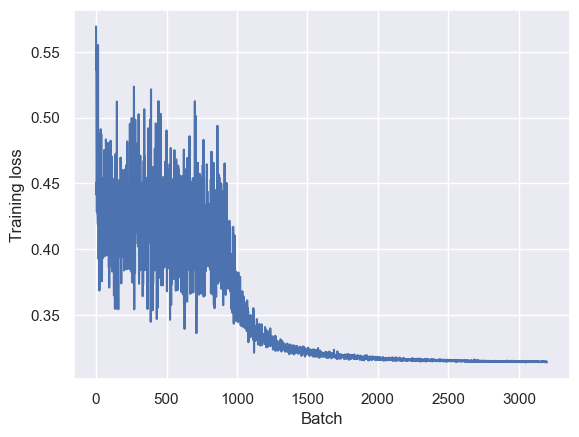

In [371]:
net = SUPagent(env).supnw.to(device)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 100

_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=device)